# <mark>Attention!</mark>

This project was originally made in the Russian language and was translated using Google translator.I didn't have too much time to check whether everything is super correct.

P.S. Most of the projects starting from `Module 2` are made in English.

# Project description
Your project is to prepare a report for a bank’s loan division. You’ll need to find out if a customer’s marital status and number of children have an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.
Your report will be considered when building a **credit score** for a potential customer. A **credit score** is used to evaluate the ability of a potential borrower to repay their loan.

## Step 1. Data overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# load stemming library
from pymystem3 import Mystem
# load stemming and tokenazing library
from nltk import word_tokenize, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')

try:
    bank_data = pd.read_csv('datasets/credit_scoring_eng.csv')
except:
    print('Wrong file path!')

bank_data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


Overall data frame info

In [2]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Let's look at the unique values of an every column

In [3]:
for column in bank_data.columns:
    print(f'Column {column} has such unique values:\n {bank_data[column].unique()}\n')

Column children has such unique values:
 [ 1  0  3  2 -1  4 20  5]

Column days_employed has such unique values:
 [-8437.67302776 -4024.80375385 -5623.42261023 ... -2113.3468877
 -3112.4817052  -1984.50758853]

Column dob_years has such unique values:
 [42 36 33 32 53 27 43 50 35 41 40 65 54 56 26 48 24 21 57 67 28 63 62 47
 34 68 25 31 30 20 49 37 45 61 64 44 52 46 23 38 39 51  0 59 29 60 55 58
 71 22 73 66 69 19 72 70 74 75]

Column education has such unique values:
 ["bachelor's degree" 'secondary education' 'Secondary Education'
 'SECONDARY EDUCATION' "BACHELOR'S DEGREE" 'some college'
 'primary education' "Bachelor's Degree" 'SOME COLLEGE' 'Some College'
 'PRIMARY EDUCATION' 'Primary Education' 'Graduate Degree'
 'GRADUATE DEGREE' 'graduate degree']

Column education_id has such unique values:
 [0 1 2 3 4]

Column family_status has such unique values:
 ['married' 'civil partnership' 'widow / widower' 'divorced' 'unmarried']

Column family_status_id has such unique values:
 [0 1 2 

Let's check look at the histograms of the columns with numbers

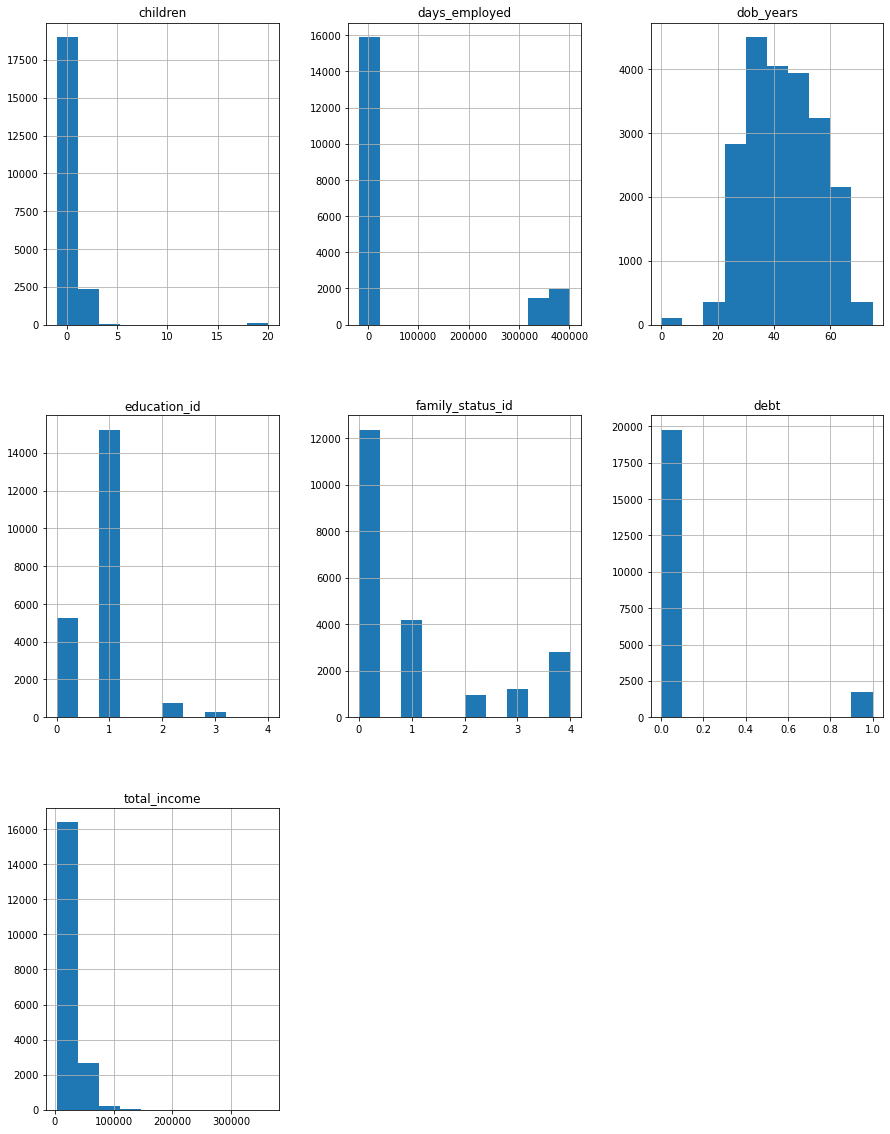

In [4]:
bank_data.hist(figsize=(15,20))
plt.show()

#### Conclusion
**Found problems**

- After the initial analysis of the data, it is clear that they have enough problems: for example, a negative number of days of work experience, or the experience and income are converted to the float type (casting to the int type makes sense because you cannot be employed for half a working day, and cutting off the fractional part of income will not have a significant impact on the credit rating, given the order of the numbers, it will also make the data more readable, save memory and speed up processing);
- the `education` column contains various duplicates;
- the column `purpose` needs lemmatization and categorization.
- Categorization by level of education and marital status is not entirely correct and this needs to be corrected.
- For the `income_type` column, you need to do a numerical categorization.
- For the `gender` column, you need to do a numerical categorization.
- The `children` column has a negative number of children and an outlier of 20 children.
- The `days_employed` column has very strong outliers that are equal to about a thousand(!) years of work experience.


Pros:

- table names are spelled correctly;
- there are no very large, intractable problems.

## Step 2. Data preprocessing

### Handling skips and other issues

In [5]:
# look for the number of gaps
bank_data.isnull().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [6]:
# look closely at data that has gaps
bank_data[bank_data.days_employed.isnull()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding


##### Fixing problems in the `education` column:

In [7]:
#look at the unique values in the "education" column. 
bank_data.education.unique()

array(["bachelor's degree", 'secondary education', 'Secondary Education',
       'SECONDARY EDUCATION', "BACHELOR'S DEGREE", 'some college',
       'primary education', "Bachelor's Degree", 'SOME COLLEGE',
       'Some College', 'PRIMARY EDUCATION', 'Primary Education',
       'Graduate Degree', 'GRADUATE DEGREE', 'graduate degree'],
      dtype=object)

In [8]:
# find duplicates and remove them
bank_data.education = bank_data.education.str.lower()
bank_data.education.unique()

array(["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree'], dtype=object)

##### Fixing problems in the `days_employed` column:

In [9]:
# In the data on the number of working days, there are many minuses by mistake - we will remove them
bank_data.days_employed = abs(bank_data.days_employed)
bank_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,5623.422610,33,secondary education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding


In [10]:
# look closely at data that has gaps
bank_data[bank_data.days_employed.isnull()].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding


In [11]:
# remove gaps in days_employed. Everything works plus or minus the same, so you can fill in the median
bank_data.days_employed.fillna(bank_data.days_employed.median(), inplace=True)
bank_data.isnull().sum()

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

<AxesSubplot:xlabel='days_employed'>

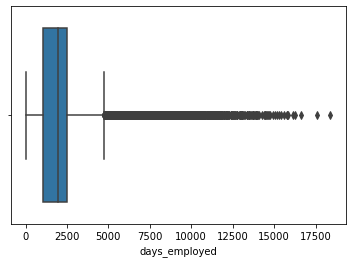

In [12]:
# Gaps filled with median. we need to fix the outliers in the "days_employed" column.
# Assume that seniority cannot exceed 60 years (~22000 days). Find the median over
# number of business days excluding these outliers and filling out the outliers by this median.

days_employed_median_corr = bank_data[bank_data.days_employed<=22000].days_employed.median()
bank_data.days_employed = bank_data.days_employed.apply(lambda x: days_employed_median_corr if x>=22000 else x)
sns.boxplot(x=bank_data.days_employed)

##### Fixing issues in the column `total_income`:

In [13]:
%%time
# Far from the most optimal method, but I have already tried functions with apply() and lambdas,
# and could not get them to work correctly

# The idea is as follows - it is incorrect to set the median income to all gaps, taking into account
# that income is highly dependent on profession and education. In this method, I expose
# missing median income according to their occupation and level of education

# go through the all array
for i in range(len(bank_data)):
    # check if inclome is NaN type 
    if bank_data.loc[i, 'total_income'] != bank_data.loc[i, 'total_income']:
        # record the person's profession
        occupation = bank_data.loc[i, 'income_type']
        # write down the level of education of a person
        education = bank_data.loc[i, 'education']
        # calculate the median income according to these two parametrs
        median_occupation_income = bank_data[(bank_data['income_type']==occupation)
                                             & (bank_data['education']==education)].total_income.median()
        bank_data.loc[i, 'total_income'] = median_occupation_income
bank_data.isnull().sum()

Wall time: 28.5 s


children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

##### Fixing problems in the column `children`

In [14]:
bank_data.children.unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

In [15]:
# negative values are clearly written by mistake - take the data modulo
bank_data.children = abs(bank_data.children)
bank_data.children.unique()

array([ 1,  0,  3,  2,  4, 20,  5], dtype=int64)

In [16]:
# Twenty children is also clearly impossible, given that the past maximum value is 5.
# Someone obviously accidentally added an extra zero at the end - it happens. Let's replace twenties with twos.

bank_data.children = bank_data.children.apply(lambda x: 2 if x==20 else x)
bank_data.children.unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

##### Fixing problems in the column `family_status`
(one of the values is capitalized)

In [17]:
bank_data.family_status.unique()

array(['married', 'civil partnership', 'widow / widower', 'divorced',
       'unmarried'], dtype=object)

In [18]:
bank_data.family_status = bank_data.family_status.str.lower()
bank_data.family_status.unique()

array(['married', 'civil partnership', 'widow / widower', 'divorced',
       'unmarried'], dtype=object)

##### Fixing problems in the column `dob_years `
(there is zero in some of the values)

In [19]:
bank_data.dob_years.unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

In [20]:
#Display the number of given values on the screen
len(bank_data[bank_data.dob_years==0])

101

In [21]:
#Display these values on the screen
bank_data[bank_data.dob_years==0].head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,1960.297207,0,secondary education,1,married,0,F,retiree,0,11406.644,car
149,0,2664.273168,0,secondary education,1,divorced,3,F,employee,0,11228.230,housing transactions
270,3,1872.663186,0,secondary education,1,married,0,F,employee,0,16346.633,housing renovation
578,0,1960.297207,0,secondary education,1,married,0,F,retiree,0,15619.310,construction of own property
1040,0,1158.029561,0,bachelor's degree,0,divorced,3,F,business,0,48639.062,to own a car


Filling in all missing values with the median age would be incorrect. All categories except for the `retiree` category must be filled in by the median age, excluding pensioners. Fill in the `retiree` category with the median age of the same category.

In [22]:
#find the median age for all categories, except for pensioners
median_age = int(bank_data[bank_data.income_type != 'retiree'].dob_years.median())
median_age

39

In [23]:
# find the median age of pensioners
median_age_retired = int(bank_data[bank_data.income_type=='retiree'].dob_years.median())
median_age_retired

60

In [24]:
bank_data[(bank_data.dob_years==0) & (bank_data.income_type != 'retiree')].dob_years = median_age
bank_data[(bank_data.dob_years==0) & (bank_data.income_type == 'retiree')].dob_years = median_age_retired
bank_data.dob_years.unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75], dtype=int64)

**Conclusion**

We have found and removed duplicates in the column on education, removed the minus in the column on the number of working days and filled in the missing values ​​according to the median. Gaps in income values ​​were filled with median values ​​according to profession and level of education. The zeros in the "age" column for pensioners were filled with the median values ​​of the age of pensioners, and all other categories were given just the median age. In the "marital status" column, all values ​​were converted to lower case. Negative values ​​from the "number of children" column resulted in a modulus. We replaced the outliers in the "length of service" column with the median values ​​of the length of service.

Minuses in the data may appear due to errors and / or typos in the code of the program that uploaded the data. The same applies to emissions. Errors in the register of writing categorical variables are most likely a human factor.

As a result, we have cleared the data of errors and can proceed to further processing.

### Replacing the data type

In [25]:
# Convert the data in the days_employed and total_income columns to integer values using the .astype(int) method

bank_data.days_employed = bank_data.days_employed.astype(int)
bank_data.total_income = bank_data.total_income.astype(int)
bank_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,bachelor's degree,0,married,0,F,employee,0,40620,purchase of the house
1,1,4024,36,secondary education,1,married,0,F,employee,0,17932,car purchase
2,0,5623,33,secondary education,1,married,0,M,employee,0,23341,purchase of the house
3,3,4124,32,secondary education,1,married,0,M,employee,0,42820,supplementary education
4,0,1960,53,secondary education,1,civil partnership,1,F,retiree,0,25378,to have a wedding


**Conclusion**

This transformation will make the data more visual by cutting off unnecessary fractional parts in the `days_employed` and `total_income` columns. Cutting off the fractional part in the total_income column will not affect the borrower's reliability assessment. the order of figures in income is quite large.

### Lemmatisation

Let's analyze the speed of categorization using lemmatisation, stemming and "in a simple way" for the column `purpose`

In [26]:
bank_data.purpose.unique()

array(['purchase of the house', 'car purchase', 'supplementary education',
       'to have a wedding', 'housing transactions', 'education',
       'having a wedding', 'purchase of the house for my family',
       'buy real estate', 'buy commercial real estate',
       'buy residential real estate', 'construction of own property',
       'property', 'building a property', 'buying a second-hand car',
       'buying my own car', 'transactions with commercial real estate',
       'building a real estate', 'housing',
       'transactions with my real estate', 'cars', 'to become educated',
       'second-hand car purchase', 'getting an education', 'car',
       'wedding ceremony', 'to get a supplementary education',
       'purchase of my own house', 'real estate transactions',
       'getting higher education', 'to own a car', 'purchase of a car',
       'profile education', 'university education',
       'buying property for renting out', 'to buy a car',
       'housing renovation', 'going

In [27]:
# %%time
# # Categorization with lemmatization

# #function for lemmatizing and joining words together
# def lemmatize_text(text):
#     m = Mystem()
#     result = m.lemmatize(text)
#     return " ".join(result)

# #categorize by lemmatized words
# def purpose_category(text):
#     if 'house' in lemmatize_text(text):
#         return 1
#     elif 'car' in lemmatize_text(text):
#         return 2
#     elif 'education' in lemmatize_text(text):
#         return 3
#     elif 'estate' in lemmatize_text(text):
#         return 4
#     elif 'wedding' in lemmatize_text(text):
#         return 5
#     else:
#         return 6

# test = bank_data['purpose'].head().apply(purpose_category)

Lemmatisation - 13 seconds for 5 lines, that's ~ 2.5 seconds for one line. Given that we have 21 thousand rows, it will take ~ 52 thousand seconds (~ 15 hours) to process the entire table using lemmatization. Unacceptably long.

In [28]:
%%time
# Categorization with stemming

stemmer = SnowballStemmer('english')

# a function for text tokenization and stemming with subsequent return of text
def stemm_text(text):
    token_words = word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# function for categorization by stemming
def purpose_category(text):
    if 'house' in stemm_text(text):
        return 1
    elif 'car' in stemm_text(text):
        return 2
    elif 'educat' in stemm_text(text):
        return 3
    elif 'estate' in stemm_text(text):
        return 4
    elif 'wedd' in stemm_text(text):
        return 5
    else:
        return 6
    
test = bank_data['purpose'].apply(purpose_category)

Wall time: 29.8 s


Получается на порядки быстрее лемматизации (приблизительно 13 секунд на всю таблицу).

In [29]:
%%time

# Categorization "in a simple way" - search for substrings in the text

def purpose_category(text):
    if 'house' in text:
        return 1
    elif 'car' in text:
        return 2
    elif 'educat' in text:
        return 3
    elif 'estate' in text:
        return 4
    elif 'wedd' in text:
        return 5
    else:
        return 6

test = bank_data['purpose'].apply(purpose_category)

Wall time: 38.7 ms


"In a simple way" turns out to be orders of magnitude faster than lemmatization and stemming (a couple of milliseconds for the entire table). This method is not as reliable as lemmatization, but the result will be no worse than stemming. Perhaps we will use this method.

**Conclusion**

Lemmatisation (at least on my laptop) takes too long to make sense to apply it to this problem. And stemming by result will not differ from a simple search for a substring.

### Data categorization

##### Categorizing the column `purpose`

In [30]:
# Let's categorize the purpose column "in a simple way":
bank_data['purpose_id'] = bank_data['purpose'].apply(purpose_category)
bank_data[['purpose', 'purpose_id']].head(10)

,purpose,purpose_id
0,purchase of the house,1
1,car purchase,2
2,purchase of the house,1
3,supplementary education,3
4,to have a wedding,5
5,purchase of the house,1
6,housing transactions,6
7,education,3
8,having a wedding,5
9,purchase of the house for my family,1


##### Categorizing the column `days_employed`

In [31]:
# Categorization by the days_employed column using apartments.
quant_cat_empl = bank_data.days_employed.quantile([.25, .5, 0.75, 1])

In [32]:
# Categorize by days_employed column using quartiles
bank_data['days_employed_id'] = bank_data.apply(lambda x: 1 if x.days_employed<=quant_cat_empl[.25]
                                                                   else 2 if x.days_employed<=quant_cat_empl[.5]
                                                                   else 3 if x.days_employed<=quant_cat_empl[.75]
                                                                   else 4, axis=1)
bank_data[['days_employed', 'days_employed_id']].tail()

,days_employed,days_employed_id
21520,4529,4
21521,1960,2
21522,2113,3
21523,3112,4
21524,1984,3


##### Categorizing the column `total_income`

In [33]:
# Categorization by the total_income column using quartiles.
quant_cat_income = bank_data.total_income.quantile([.25, .5, 0.75, 1])

In [34]:
#Categorization by total_income column using quartiles
bank_data['total_income_id'] = bank_data.apply(lambda x: 1 if x.total_income<=quant_cat_income[.25]
                                                                   else 2 if x.total_income<=quant_cat_income[.5]
                                                                   else 3 if x.total_income<=quant_cat_income[.75]
                                                                   else 4, axis=1)
bank_data[['total_income', 'total_income_id']].head()

,total_income,total_income_id
0,40620,4
1,17932,2
2,23341,3
3,42820,4
4,25378,3


##### Categorizing the column  `education`

In [35]:
# Categorize data from the "education" column. Let's see the number of unique values.
bank_data.education.unique()

array(["bachelor's degree", 'secondary education', 'some college',
       'primary education', 'graduate degree'], dtype=object)

In [36]:
def education_cat(row):
    education = row['education']
    if education == 'primary education':
        return 0
    elif education == 'secondary education':
        return 1
    elif education == 'graduate degree':
        return 2
    elif education == 'some college':
        return 3
    return 4

bank_data['education_id'] = bank_data.apply(education_cat, axis=1)
bank_data[['education', 'education_id']].head()

,education,education_id
0,bachelor's degree,4
1,secondary education,1
2,secondary education,1
3,secondary education,1
4,secondary education,1


In [37]:
bank_data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_id,days_employed_id,total_income_id
0,1,8437,42,bachelor's degree,4,married,0,F,employee,0,40620,purchase of the house,1,4,4
1,1,4024,36,secondary education,1,married,0,F,employee,0,17932,car purchase,2,4,2
2,0,5623,33,secondary education,1,married,0,M,employee,0,23341,purchase of the house,1,4,3
3,3,4124,32,secondary education,1,married,0,M,employee,0,42820,supplementary education,3,4,4
4,0,1960,53,secondary education,1,civil partnership,1,F,retiree,0,25378,to have a wedding,5,2,3


##### Categorizing the column `gender`

In [38]:
bank_data.gender.unique()

array(['F', 'M', 'XNA'], dtype=object)

In [39]:
bank_data['gender_id'] = bank_data.gender.apply(lambda x: 1 if x=='M' else 2 if x=='F' else 3 if x=='XNA' else x)
bank_data[['gender', 'gender_id']].head()

,gender,gender_id
0,F,2
1,F,2
2,M,1
3,M,1
4,F,2


##### Categorizing the column  `income_type`

In [40]:
bank_data.income_type.unique()

array(['employee', 'retiree', 'business', 'civil servant', 'unemployed',
       'entrepreneur', 'student', 'paternity / maternity leave'],
      dtype=object)

In [41]:
bank_data['income_type_id'] = bank_data.income_type.apply(lambda x: 0 if x=='unemployed'
                                                          else 1 if x=='student'
                                                          else 2 if x=='paternity / maternity leave'
                                                          else 3 if x=='business'
                                                          else 4 if x=='employee'
                                                          else 5 if x=='civil servant'
                                                          else 6 if x=='entrepreneur'
                                                          else 7 if x=='retiree' else x)

bank_data[['income_type', 'income_type_id']].sample(5, random_state=88)

,income_type,income_type_id
5603,employee,4
2547,business,3
9778,employee,4
159,retiree,7
18655,employee,4


##### Categorizing the column  `dob_years`

In [42]:
bank_data['dob_years_id'] = bank_data['dob_years'].apply(lambda x: 0 if x<=17
                                                        else 1 if x<=30
                                                        else 2 if x<=60
                                                        else 3)
bank_data[['dob_years', 'dob_years_id']].tail()

,dob_years,dob_years_id
21520,43,2
21521,67,3
21522,38,2
21523,38,2
21524,40,2


##### Looking at the received data

In [43]:
bank_data = bank_data.reindex(sorted(bank_data.columns), axis=1)
bank_data.head()

,children,days_employed,days_employed_id,debt,dob_years,dob_years_id,education,education_id,family_status,family_status_id,gender,gender_id,income_type,income_type_id,purpose,purpose_id,total_income,total_income_id
0,1,8437,4,0,42,2,bachelor's degree,4,married,0,F,2,employee,4,purchase of the house,1,40620,4
1,1,4024,4,0,36,2,secondary education,1,married,0,F,2,employee,4,car purchase,2,17932,2
2,0,5623,4,0,33,2,secondary education,1,married,0,M,1,employee,4,purchase of the house,1,23341,3
3,3,4124,4,0,32,2,secondary education,1,married,0,M,1,employee,4,supplementary education,3,42820,4
4,0,1960,2,0,53,2,secondary education,1,civil partnership,1,F,2,retiree,7,to have a wedding,5,25378,3


**Conclusion**

We took up the categorization of all the necessary columns and successfully carried it out. Sorted column names by name.

### Let's look at the median income depending on education and current profession 

In [44]:
bank_data.pivot_table('total_income', index=bank_data.education_id, columns='income_type', aggfunc='median')

income_type,business,civil servant,employee,entrepreneur,paternity / maternity leave,retiree,student,unemployed
education_id,,,,,,,,
0,21887.0,23734.0,20159.0,NaN,NaN,16415.0,NaN,NaN
1,25451.0,21864.0,21848.0,NaN,8612.0,18374.0,NaN,9593.0
2,NaN,17822.0,31771.0,NaN,NaN,28334.0,NaN,NaN
3,28778.0,25694.0,24209.0,NaN,NaN,19221.0,NaN,NaN
4,32285.0,27601.0,26502.0,79866.0,NaN,23078.0,15712.0,32435.0


## Step 3: Answer the questions

- Is there a relationship between having children and repaying a loan on time?

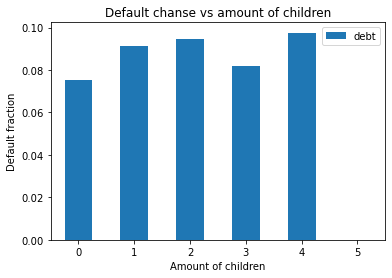

In [45]:
#titanic.pivot_table('debt', index='children', columns='class')
bank_data.groupby('children')['debt'].mean().sort_values().to_frame().sort_values('children').plot(kind='bar', rot=0)
plt.title('Default chanse vs amount of children')
plt.xlabel('Amount of children')
plt.ylabel('Default fraction')
plt.show()

In [46]:
len(bank_data[bank_data['children']==5])

9

**Conclusion**

As you can see from this table, people who have 5 children always repay loans. This is due to a too small sample - only 9 people, while there are 4865 people who have one child. From the representative data, it can be seen that people who do not have children give loans most often. At the same time, people who have three children repay loans more often than people who have 1, 2 and 4 children.

- Is there a relationship between marital status and loan repayment on time?

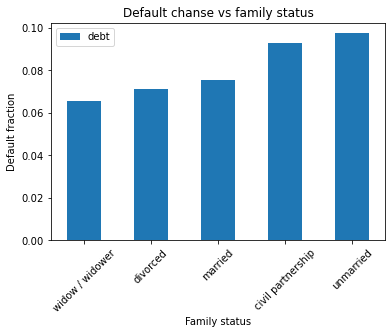

In [47]:
bank_data.groupby('family_status')['debt'].mean().sort_values().to_frame().sort_values('debt').plot(kind='bar', rot=45)
plt.title('Default chanse vs family status')
plt.xlabel('Family status')
plt.ylabel('Default fraction')
plt.show()

**Conclusion**

As we can see from the table, widows and widowers repay loans most often, and single people (single) - least often.

- Is there a relationship between income level and loan repayment on time?

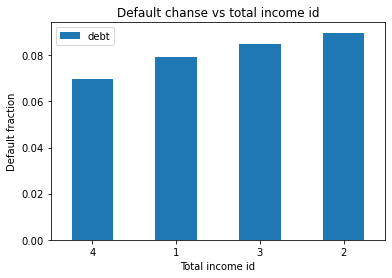

In [48]:
bank_data.groupby('total_income_id')['debt'].mean().sort_values().to_frame().sort_values('debt').plot(kind='bar', rot=0)
plt.title('Default chanse vs total income id')
plt.xlabel('Total income id')
plt.ylabel('Default fraction')
plt.show()

**Conclusion**

From the data presented, it can be seen that people with income from the fourth quartile (highest income) repay loans most often, immediately followed by people with the lowest income. People with income from the second quartile are the worst to repay loans.

- How do different purposes of a loan affect its repayment on time?

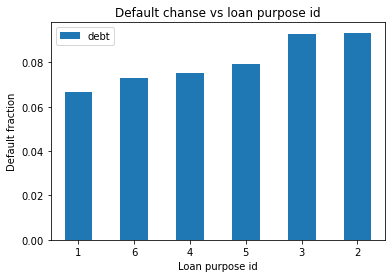

In [49]:
# housing: 1; car: 2; education: 3; real estate: 4; wedding: 5; other: 6
bank_data.groupby('purpose_id')['debt'].mean().sort_values().to_frame().sort_values('debt').plot(kind='bar', rot=0)
plt.title('Default chanse vs loan purpose id')
plt.xlabel('Loan purpose id')
plt.ylabel('Default fraction')
plt.show()

**Conclusion**

The data shows that people who take out a mortgage repay debts more often than any other category. Worst of all give loans taken to buy a car.

## Step 4. General conclusion 

The data submitted for processing contained gaps, errors, and outliers. Also, there was no categorization for a number of columns, including the purpose of the loan. All these problems have been successfully corrected and answers have been given to repay loans depending on income, marital status, etc. The project is ready to be sent to the customer.